==================================Sentiment Analysis and the Dataset============================

In [3]:
import os
import torch
from torch import nn
from d2l import torch as d2l

In [4]:
#@save
d2l.DATA_HUB['aclImdb'] = (d2l.DATA_URL + 'aclImdb_v1.tar.gz', '01ada507287d82875905620988597833ad4e0903')
data_dir = d2l.download_extract('aclImdb', 'aclImdb')

In [5]:
#@save
def read_imdb(data_dir, is_train):
    """Read the IMDb review dataset text sequences and labels."""
    data, labels = [], []
    for label in ('pos', 'neg'):
        folder_name = os.path.join(data_dir, 'train' if is_train else 'test',label)
        for file in os.listdir(folder_name):
            with open(os.path.join(folder_name, file), 'rb') as f:
                review = f.read().decode('utf-8').replace('\n', '')
                data.append(review)
                labels.append(1 if label == 'pos' else 0) # Positive review: 1, negative review: 0
    return data, labels

train_data = read_imdb(data_dir, is_train=True)
print('# training examples:', len(train_data[0]))
for x, y in zip(train_data[0][:3], train_data[1][:3]):
    print('label:', y, 'review:', x[:60])

# training examples: 25000
label: 1 review: This low budget digital video film has strengths in the righ
label: 1 review: My, Kasi Lemmings certainly is a fair looking woman. This fi
label: 1 review: THis was a hilarious movie and I would see it again and agai


In [6]:
# train_tokens is a list of list of words
train_tokens = d2l.tokenize(train_data[0], token='word')
print("Number of sentences: ", len(train_tokens))

vocab = d2l.Vocab(train_tokens, min_freq=5, reserved_tokens=['<pad>'])
print("number of distinct words: ", len(vocab))

# vocab is the set of unique word types that survived:
    # appearing ≥ min_freq=5
    # plus '<pad>'

Number of sentences:  25000
number of distinct words:  49347


In [7]:
# train_tokens is a list of list of words

# print out first 3 sentences
print(train_tokens[0]) # first sentence
print(train_tokens[1]) # second sentence
print(train_tokens[2]) # third sentence

['This', 'low', 'budget', 'digital', 'video', 'film', 'has', 'strengths', 'in', 'the', 'right', 'places--writing', 'and', 'acting.', 'In', 'addition', 'the', 'digital', 'photography', 'is', 'the', 'best', 'of', 'the', 'lot', 'so', 'far.', 'In', 'low', 'light', 'conditions', 'the', 'characteristic', 'video', 'umber', 'tone', 'prevails', 'but,', 'surprising,', 'it', 'rivals', 'film', 'stock', 'for', 'brightness,', 'clarity,', 'and,', 'saturation', 'in', 'brightly', 'lit', 'situations.', 'This', 'is', 'grass', 'roots', 'film', 'making', 'at', 'its', 'best', 'with', 'snappy', 'dialogue', 'carrying', 'a', '"Midnight', 'Cowboy"', 'kind', 'of', 'story', 'about', 'grifters', 'doing', 'whatever', 'it', 'takes', 'to', 'survive', 'in', 'urban', 'San', 'Francisco.']
['My,', 'Kasi', 'Lemmings', 'certainly', 'is', 'a', 'fair', 'looking', 'woman.', 'This', 'film', 'is', 'a', 'lost', 'gem,', 'a', 'dead-on', 'satire', '"mockumentary"', 'of', 'the', 'early', "90's", 'Hip', 'Hop', 'scene,', 'when', 'MC',

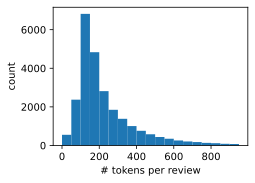

In [8]:
d2l.set_figsize()
d2l.plt.xlabel('# tokens per review')
d2l.plt.ylabel('count')
d2l.plt.hist([len(line) for line in train_tokens], bins=range(0, 1000, 50));

In [9]:
# To process a minibatch of such reviews at each time, we set the length of each review to 500 with truncation and padding.

num_steps = 500  # sequence length
train_features = torch.tensor([d2l.truncate_pad(
    vocab[line], num_steps, vocab['<pad>']) for line in train_tokens])
print(train_features.shape)

torch.Size([25000, 500])


In [10]:
# print first setence tokens
print(vocab[train_tokens[0]])

[15871, 33910, 20839, 24924, 47807, 28005, 30257, 44290, 31580, 45586, 40859, 3681, 18388, 17599, 9710, 17718, 45586, 24924, 37886, 32452, 45586, 19968, 36449, 45586, 33838, 43158, 27633, 9710, 33910, 33477, 22883, 45586, 21658, 47807, 3681, 46173, 38805, 20983, 44864, 32497, 40940, 28005, 44112, 28546, 3681, 22060, 18389, 41397, 31580, 20729, 33621, 42781, 15871, 32452, 29695, 41088, 28005, 34143, 19076, 32554, 19968, 48797, 43108, 24812, 21334, 17311, 403, 6448, 32873, 36449, 44180, 17366, 3681, 25478, 48526, 32497, 45140, 46106, 44892, 31580, 47547, 14351, 8202]


In [11]:
# create data iterators. At each iteration, a minibatch of 64 examples are returned.
train_iter = d2l.load_array((train_features, torch.tensor(train_data[1])), 64)

for X, y in train_iter:
    print('One batch: X:', X.shape, ', y:', y.shape)
    break
print('# batches:', len(train_iter))

One batch: X: torch.Size([64, 500]) , y: torch.Size([64])
# batches: 391


In [12]:
# Let's wrap up the above steps into the load_data_imdb function. 
# It returns training and test data iterators and the vocabulary of the IMDb review dataset.

#@save
def load_data_imdb(batch_size, num_steps=500):
    """Return data iterators and the vocabulary of the IMDb review dataset."""
    data_dir = d2l.download_extract('aclImdb', 'aclImdb')
    train_data = read_imdb(data_dir, is_train=True)
    test_data = read_imdb(data_dir, is_train=False)
    train_tokens = d2l.tokenize(train_data[0], token='word')
    test_tokens = d2l.tokenize(test_data[0], token='word')
    vocab = d2l.Vocab(train_tokens, min_freq=5)
    train_features = torch.tensor([d2l.truncate_pad(vocab[line], num_steps, vocab['<pad>']) for line in train_tokens])
    test_features = torch.tensor([d2l.truncate_pad(vocab[line], num_steps, vocab['<pad>']) for line in test_tokens])
    train_iter = d2l.load_array((train_features, torch.tensor(train_data[1])),batch_size)
    test_iter = d2l.load_array((test_features, torch.tensor(test_data[1])),batch_size,is_train=False)
    return train_iter, test_iter, vocab

====================================Sentiment Analysis: Using Recurrent Neural Networks===============================

![as](./Images/GloVeRNN.png)

In [13]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size = 64
train_iter, test_iter, vocab = d2l.load_data_imdb(batch_size)

In [14]:
class BiRNN(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, **kwargs):
        super(BiRNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # Set `bidirectional` to True to get a bidirectional RNN
        self.encoder = nn.LSTM(embed_size, num_hiddens, num_layers=num_layers, bidirectional=True)
        self.decoder = nn.Linear(4 * num_hiddens, 2)

    def forward(self, inputs):
        # inputs: (batch size, no. of time steps).
        # LSTM requires its input's first dimension to be the temporal dimension.
        # inputs.T: (no. of time steps, batch size)
        # embedding: (no. of time steps, batch size, word vector dimension)
        embeddings = self.embedding(inputs.T)

        self.encoder.flatten_parameters()
        # Returns hidden states of the last hidden layer at different time steps.
        # outputs: (no. of time steps, batch size, 2 * num_hiddens)
        outputs, _ = self.encoder(embeddings)

        # Concatenate the hidden states at the initial and final time steps as
        # the input of the fully connected layer.
        # encoding: (batch size, 4 * num_hiddens)
        encoding = torch.cat((outputs[0], outputs[-1]), dim=1)

        # encoding: (batch size, 2)
        outs = self.decoder(encoding)
        return outs

In [15]:
embed_size, num_hiddens, num_layers, devices = 100, 100, 2, d2l.try_all_gpus()
net = BiRNN(len(vocab), embed_size, num_hiddens, num_layers)

def init_weights(module):
    if type(module) == nn.Linear:
        nn.init.xavier_uniform_(module.weight)
    if type(module) == nn.LSTM:
        for param in module._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(module._parameters[param])
net.apply(init_weights);

In [24]:
glove_embedding = d2l.TokenEmbedding('glove.6b.100d') # 400k vectors
embeds = glove_embedding[vocab.idx_to_token]  # only our used words
embeds.shape

torch.Size([49346, 100])

In [ ]:
# We use these pretrained word vectors to represent tokens in the reviews and will not update these vectors during training.

net.embedding.weight.data.copy_(embeds)
net.embedding.weight.requires_grad = False

KeyboardInterrupt: 

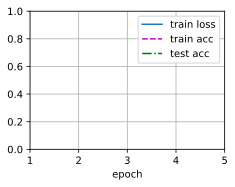

In [26]:
lr, num_epochs = 0.01, 5
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")

# make sure you gave gpu, otherwise it will crash with list index out of range
devices = d2l.try_all_gpus()
if not devices:
    devices = [torch.device('cpu')] # this is going to take very long time
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

In [ ]:
#@save
def predict_sentiment(net, vocab, sequence):
    """Predict the sentiment of a text sequence."""
    sequence = torch.tensor(vocab[sequence.split()], device=d2l.try_gpu())
    label = torch.argmax(net(sequence.reshape(1, -1)), dim=1)
    return 'positive' if label == 1 else 'negative'

In [ ]:
predict_sentiment(net, vocab, 'this movie is so great')

In [ ]:
predict_sentiment(net, vocab, 'this movie is so bad')

======================================Sentiment Analysis: Using Convolutional Neural Networks=======================

![GloVE attention](./Images/GloveCNN.png)

In [27]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size = 64
train_iter, test_iter, vocab = d2l.load_data_imdb(batch_size)

![1d cross-correlation](./Images/corr1d.png)

In [28]:

def corr1d(X, K):
    w = K.shape[0]
    Y = torch.zeros((X.shape[0] - w + 1))
    for i in range(Y.shape[0]):
        Y[i] = (X[i: i + w] * K).sum()
    return Y

In [29]:
X, K = torch.tensor([0, 1, 2, 3, 4, 5, 6]), torch.tensor([1, 2])
corr1d(X, K)

tensor([ 2.,  5.,  8., 11., 14., 17.])

![1d cross-correlation](./Images/corr1d-multi-in.png)

In [ ]:
def corr1d_multi_in(X, K):
    # First, iterate through the 0th dimension (channel dimension) of `X` and
    # `K`. Then, add them together
    return sum(corr1d(x, k) for x, k in zip(X, K))

X = torch.tensor([[0, 1, 2, 3, 4, 5, 6],
                  [1, 2, 3, 4, 5, 6, 7],
                  [2, 3, 4, 5, 6, 7, 8]])
K = torch.tensor([[1, 2], [3, 4], [-1, -3]])
corr1d_multi_in(X, K)

Note that multi-input-channel one-dimensional cross-correlations are equivalent to single-input-channel two-dimensional cross-correlations.

![1d cross-correlation](./Images/corr2d.png)


#### The *textCNN* Model — Sentiment Analysis with CNNs

##### Overview

- This section introduces **textCNN**, a **one-dimensional convolutional neural network (CNN)** designed for **sentiment analysis**.
- It adapts CNNs from computer vision to natural language by sliding convolutional filters over **word embedding sequences**.


##### Model Intuition

1. **Input Representation**
   - A sentence with $ n $ tokens is represented as a sequence of $ d $-dimensional word embeddings.
   - Conceptually, this forms a 1D “image” with:
     - width = number of tokens
     - channels = embedding dimension

2. **Convolution Layers**
   - Multiple **1D convolution kernels with different widths** (e.g., 2, 3, 4) are applied in parallel.
   - Each kernel width captures local **n-gram features** of different sizes.
   - Each convolution produces multiple output channels (feature maps).

3. **Max-Over-Time Pooling**
   - For each output channel, **global max pooling** is applied over the time (sequence) dimension.
   - This selects the most salient feature value from each channel.
   - Pooling converts variable-length sequences into fixed-length representations.

4. **Classification Layer**
   - All pooled features from different kernel sizes are **concatenated** into a single vector.
   - This vector is passed through:
     - a fully connected layer
     - optional dropout
   - The final output predicts sentiment classes (e.g., positive or negative).

##### Key Architectural Characteristics

- **Parallel convolutions** allow the model to capture patterns at multiple context lengths simultaneously.
- **Global max pooling** provides robustness to sentence length and position of key phrases.
- The model can combine:
  - **trainable embeddings** (adapted during training)
  - **fixed pretrained embeddings** (e.g., GloVe) for stability and generalization.

##### Performance Characteristics

- textCNN performs competitively on sentiment analysis benchmarks such as IMDb.
- It often matches RNN-based models in accuracy while being:
  - simpler
  - faster to train
  - easier to parallelize

##### Takeaway

- textCNN applies **1D convolution + global pooling** to word embeddings for text classification.
- It efficiently captures local semantic patterns without recurrence.
- The architecture is simple, effective, and computationally efficient for sentiment analysis tasks.

![text CNN](./Images/textCNN.png)

In [ ]:
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embed_size, kernel_sizes, num_channels,
                 **kwargs):
        super(TextCNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # The embedding layer not to be trained
        self.constant_embedding = nn.Embedding(vocab_size, embed_size)
    
        self.dropout = nn.Dropout(0.5)
        self.decoder = nn.Linear(sum(num_channels), 2)
        # The max-over-time pooling layer has no parameters, so this instance
        # can be shared
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.relu = nn.ReLU()
        # Create multiple one-dimensional convolutional layers
        self.convs = nn.ModuleList()
        for c, k in zip(num_channels, kernel_sizes):
            self.convs.append(nn.Conv1d(2 * embed_size, c, k))

    def forward(self, inputs):
        # Concatenate two embedding layer outputs with shape (batch size, no.
        # of tokens, token vector dimension) along vectors
        embeddings = torch.cat((self.embedding(inputs), self.constant_embedding(inputs)), dim=2)
        # Per the input format of one-dimensional convolutional layers,
        # rearrange the tensor so that the second dimension stores channels
        # shape: (batch size, 2*embed_size, no. of tokens)
        embeddings = embeddings.permute(0, 2, 1) 
        # For each one-dimensional convolutional layer, after max-over-time
        # pooling, a tensor of shape (batch size, no. of channels, 1) is
        # obtained. Remove the last dimension and concatenate along channels
        # encoding shape: (batch size, sum(num_channels))
        encoding = torch.cat([
            torch.squeeze(self.relu(self.pool(conv(embeddings))), dim=-1)
            for conv in self.convs], dim=1)
        outputs = self.decoder(self.dropout(encoding))
        return outputs

In [ ]:
embed_size, kernel_sizes, nums_channels = 100, [3, 4, 5], [100, 100, 100]
devices = d2l.try_all_gpus()
net = TextCNN(len(vocab), embed_size, kernel_sizes, nums_channels)

def init_weights(module):
    if type(module) in (nn.Linear, nn.Conv1d):
        nn.init.xavier_uniform_(module.weight)

net.apply(init_weights);

In [ ]:
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')
embeds = glove_embedding[vocab.idx_to_token]
net.embedding.weight.data.copy_(embeds)
net.constant_embedding.weight.data.copy_(embeds)
net.constant_embedding.weight.requires_grad = False

In [ ]:
lr, num_epochs = 0.001, 5
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

In [ ]:
d2l.predict_sentiment(net, vocab, 'this movie is so great')

In [ ]:
d2l.predict_sentiment(net, vocab, 'this movie is so bad')

======================================Natural Language Inference and the Dataset===========================================

**Natural language inference** studies whether a hypothesis can be inferred from a premise, where both are a text sequence. In other words, natural language inference determines the logical relationship between a pair of text sequences. Such relationships usually fall into three types:

Entailment: the hypothesis can be inferred from the premise.

Contradiction: the negation of the hypothesis can be inferred from the premise.

Neutral: all the other cases.

In [1]:
import os
import re
import torch
from torch import nn
from d2l import torch as d2l

#@save
d2l.DATA_HUB['SNLI'] = (
    'https://nlp.stanford.edu/projects/snli/snli_1.0.zip',
    '9fcde07509c7e87ec61c640c1b2753d9041758e4')

data_dir = d2l.download_extract('SNLI')

In [2]:
#@save
def read_snli(data_dir, is_train):
    """Read the SNLI dataset into premises, hypotheses, and labels."""
    def extract_text(s):
        # Remove information that will not be used by us
        s = re.sub('\\(', '', s)
        s = re.sub('\\)', '', s)
        # Substitute two or more consecutive whitespace with space
        s = re.sub('\\s{2,}', ' ', s)
        return s.strip()
    label_set = {'entailment': 0, 'contradiction': 1, 'neutral': 2}
    file_name = os.path.join(data_dir, 'snli_1.0_train.txt'
                             if is_train else 'snli_1.0_test.txt')
    with open(file_name, 'r') as f:
        rows = [row.split('\t') for row in f.readlines()[1:]]
    premises = [extract_text(row[1]) for row in rows if row[0] in label_set]
    hypotheses = [extract_text(row[2]) for row in rows if row[0] in label_set]
    labels = [label_set[row[0]] for row in rows if row[0] in label_set]
    return premises, hypotheses, labels

In [ ]:
train_data = read_snli(data_dir, is_train=True)
for x0, x1, y in zip(train_data[0][:3], train_data[1][:3], train_data[2][:3]):
    print('premise:', x0)
    print('hypothesis:', x1)
    print('label:', y)

premise: A person on a horse jumps over a broken down airplane .
hypothesis: A person is training his horse for a competition .
label: 2
premise: A person on a horse jumps over a broken down airplane .
hypothesis: A person is at a diner , ordering an omelette .
label: 1
premise: A person on a horse jumps over a broken down airplane .
hypothesis: A person is outdoors , on a horse .
label: 0


In [4]:
# The following shows that the three labels “entailment”, “contradiction”, and “neutral” are balanced in both the training set and the testing set.

test_data = read_snli(data_dir, is_train=False)
for data in [train_data, test_data]:
    print([[row for row in data[2]].count(i) for i in range(3)])

[183416, 183187, 182764]
[3368, 3237, 3219]


In [ ]:
#@save
class SNLIDataset(torch.utils.data.Dataset):
    """A customized dataset to load the SNLI dataset."""
    def __init__(self, dataset, num_steps, vocab=None):
        self.num_steps = num_steps
        all_premise_tokens = d2l.tokenize(dataset[0])
        all_hypothesis_tokens = d2l.tokenize(dataset[1])
        if vocab is None:
            self.vocab = d2l.Vocab(all_premise_tokens + all_hypothesis_tokens,
                                   min_freq=5,
                                   reserved_tokens=['<pad>'])
        else:
            self.vocab = vocab
        self.premises = self._pad(all_premise_tokens)
        self.hypotheses = self._pad(all_hypothesis_tokens)
        self.labels = torch.tensor(dataset[2])
        print('read ' + str(len(self.premises)) + ' examples')

    def _pad(self, lines):
        return torch.tensor([d2l.truncate_pad(
                                self.vocab[line],
                                self.num_steps,
                                self.vocab['<pad>'])
                         for line in lines])

    def __getitem__(self, idx):
        return (self.premises[idx], self.hypotheses[idx]), self.labels[idx]

    def __len__(self):
        return len(self.premises)

In [ ]:
#@save
def load_data_snli(batch_size, num_steps=50):
    """Download the SNLI dataset and return data iterators and vocabulary."""
    num_workers = d2l.get_dataloader_workers()
    data_dir = d2l.download_extract('SNLI')
    train_data = read_snli(data_dir, True)
    test_data = read_snli(data_dir, False)
    train_set = SNLIDataset(train_data, num_steps)
    test_set = SNLIDataset(test_data, num_steps, train_set.vocab)
    train_iter = torch.utils.data.DataLoader(train_set,
                                             batch_size,
                                             shuffle=True,
                                             num_workers=num_workers)
    test_iter = torch.utils.data.DataLoader(test_set,
                                            batch_size,
                                            shuffle=False,
                                            num_workers=num_workers)
    return train_iter, test_iter, train_set.vocab

In [7]:
train_iter, test_iter, vocab = load_data_snli(128, 50)
len(vocab)

read 549367 examples
read 9824 examples


/workspaces/pytorch-basics/.venv310/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


18678

===================================Natural Language Inference: Using Attention===================================

![GloVE attention](./Images/GloveAttention.png)

![Natural Language Interfernce using Attention](./Images/NeutralLanguageInferenceWithAttention.png)

#### Natural Language Inference — Using Attention

##### Overview
Natural Language Inference (NLI) is the task of determining the logical relationship between two sentences:

- a **premise** (assumed to be true), and  
- a **hypothesis** (whose truth is evaluated relative to the premise).

The possible relationships are **entailment**, **contradiction**, and **neutral**.

The **decomposable attention model** (Parikh et al., 2016) is a simple yet effective architecture for NLI. It avoids recurrent and convolutional layers entirely, relying only on **feed-forward networks and attention**. Despite its simplicity, it achieves strong performance.

The model operates in three conceptually clean stages:
1. **Attend** — softly align words in the premise with words in the hypothesis.
2. **Compare** — compare each word to what it aligns with in the other sentence.
3. **Aggregate** — combine all comparisons and predict the relationship.

##### Notation
- Premise: $\mathbf{A} = (\mathbf{a}_1, \dots, \mathbf{a}_m)$
- Hypothesis: $\mathbf{B} = (\mathbf{b}_1, \dots, \mathbf{b}_n)$
- Token vectors: $\mathbf{a}_i, \mathbf{b}_j \in \mathbb{R}^d$
- $[\,\cdot\,,\,\cdot\,]$ denotes vector concatenation.
- $f, g, h$ are learned feed-forward neural networks (MLPs).

##### 1) Attending (alignment)

**Goal:** determine which words in the premise correspond to which words in the hypothesis.

For every pair of tokens $(\mathbf{a}_i, \mathbf{b}_j)$, compute a similarity score:
$$ e_{ij} = f(\mathbf{a}_i)^\top f(\mathbf{b}_j) $$
Here, the MLP $f$ projects each token into a comparison space, and the dot product measures how related the two tokens are.

These scores are then normalized with softmax to produce **soft alignments**.

- **For each premise token $\mathbf{a}_i$:**

  The aligned hypothesis representation is:
  $
  \boldsymbol{\beta}_i
  = \sum_{j=1}^n \text{softmax}(e_{ij})\, \mathbf{b}_j
  = \sum_{j=1}^n \frac{\exp(e_{ij})}{\sum_{k=1}^n \exp(e_{ik})}\, \mathbf{b}_j
  $

  Interpretation:
  - $\boldsymbol{\beta}_i$ summarizes **what the hypothesis says about $\mathbf{a}_i$**.
  - The model asks: *“Which hypothesis words are relevant to this premise word, and how much?”*
  - The result is a weighted average of hypothesis word vectors.

- **For each hypothesis token $\mathbf{b}_j$:**

  The aligned premise representation is:
  $
  \boldsymbol{\alpha}_j
  = \sum_{i=1}^m \text{softmax}(e_{ij})\, \mathbf{a}_i
  = \sum_{i=1}^m \frac{\exp(e_{ij})}{\sum_{k=1}^m \exp(e_{kj})}\, \mathbf{a}_i
  $

  Interpretation:
  - $\boldsymbol{\alpha}_j$ summarizes **what the premise says about $\mathbf{b}_j$**.

**Computational trick (decomposability):**  
The MLP $f$ is applied independently to each token. This allows precomputation of $f(\mathbf{a}_i)$ and $f(\mathbf{b}_j)$, making the expensive part effectively linear in $m+n$ rather than quadratic.

##### 2) Comparing

**Goal:** directly compare each word with its aligned counterpart.

**Each token is paired with the information it received from the other sentence**, and the pair is processed by another MLP $g$.

- **For premise tokens:**
  $
  \mathbf{v}_{A,i}
  = g\big([\mathbf{a}_i,\, \boldsymbol{\beta}_i]\big),
  \quad i=1,\dots,m
  $

- **For hypothesis tokens:**
  $
  \mathbf{v}_{B,j}
  = g\big([\mathbf{b}_j,\, \boldsymbol{\alpha}_j]\big),
  \quad j=1,\dots,n
  $

Interpretation:
- These vectors encode **how well each word matches or conflicts with its aligned meaning**.
- The comparison is local and token-level, without modeling word order explicitly.

##### 3) Aggregating (pooling & classification)

**Goal:** combine all local comparisons into a single decision.

First, sum the comparison vectors:
$
\mathbf{v}_A = \sum_{i=1}^m \mathbf{v}_{A,i},
\qquad
\mathbf{v}_B = \sum_{j=1}^n \mathbf{v}_{B,j}
$

This produces one vector summarizing the premise-side evidence and one summarizing the hypothesis-side evidence.

Then concatenate and classify:
$ \hat{\mathbf{y}} = h\big([\mathbf{v}_A,\, \mathbf{v}_B]\big) $

The output $\hat{\mathbf{y}}$ contains scores or probabilities over the NLI labels:
**entailment**, **contradiction**, and **neutral**.


In [8]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [9]:
def mlp(num_inputs, num_hiddens, flatten):
    net = []
    net.append(nn.Dropout(0.2))
    net.append(nn.Linear(num_inputs, num_hiddens))
    net.append(nn.ReLU())
    if flatten:
        net.append(nn.Flatten(start_dim=1))
    net.append(nn.Dropout(0.2))
    net.append(nn.Linear(num_hiddens, num_hiddens))
    net.append(nn.ReLU())
    if flatten:
        net.append(nn.Flatten(start_dim=1))
    return nn.Sequential(*net)

In [ ]:
class Attend(nn.Module):
    def __init__(self, num_inputs, num_hiddens, **kwargs):
        super(Attend, self).__init__(**kwargs)
        self.f = mlp(num_inputs, num_hiddens, flatten=False)

    def forward(self, A, B):
        # A/B: (batch_size, no. of tokens in sequence A/B, embed_size)
        # f_A/f_B: (batch_size, no. of tokens in sequence A/B, num_hiddens)
        f_A = self.f(A)
        f_B = self.f(B)
    
        # e is attention weights
        # e: (batch_size, no. of tokens in sequence A, no. of tokens in sequence B)
        e = torch.bmm(f_A, f_B.permute(0, 2, 1))

        # F.softmax(e, dim=-1): (batch_size, no. of tokens in sequence A, no. of tokens in sequence B)
        # Softmax is applied independently for each (batch_size, premise_token) pair. Softmax does NOT change shape.
        # beta: (batch_size, no. of tokens in sequence A, embed_size)
        # where sequence B is softly aligned with each token in sequence A
        beta = torch.bmm(F.softmax(e, dim=-1), B)

        # alpha: (batch_size, no. of tokens in sequence B, embed_size)
        # where sequence A is softly aligned with each token in sequence B
        alpha = torch.bmm(F.softmax(e.permute(0, 2, 1), dim=-1), A)
        return beta, alpha

In [12]:
class Compare(nn.Module):
    def __init__(self, num_inputs, num_hiddens, **kwargs):
        # num_inputs = 2 * embed_size
        super(Compare, self).__init__(**kwargs)
        self.g = mlp(num_inputs, num_hiddens, flatten=False)

    def forward(self, A, B, beta, alpha):
        # A:     (batch_size, no. of tokens in sequence A, embed_size)
        # B:     (batch_size, no. of tokens in sequence B, embed_size)
        # beta:  (batch_size, no. of tokens in sequence A, embed_size)
        # alpha: (batch_size, no. of tokens in sequence B, embed_size)

        # torch.cat([A, beta]: (batch_size, no. of tokens in sequence A, 2 * embed_size)
        # torch.cat([B, beta]: (batch_size, no. of tokens in sequence B, 2 * embed_size)

        # V_A: (batch_size, no. of tokens in sequence A, num_hiddens)
        # V_B: (batch_size, no. of tokens in sequence B, num_hiddens)
        V_A = self.g(torch.cat([A, beta], dim=2))
        V_B = self.g(torch.cat([B, alpha], dim=2))
        return V_A, V_B

In [ ]:
class Aggregate(nn.Module):
    def __init__(self, num_inputs, num_hiddens, num_outputs, **kwargs):
        # num_inputs = 2 * num_hiddens
        super(Aggregate, self).__init__(**kwargs)
        self.h = mlp(num_inputs, num_hiddens, flatten=True)
        self.linear = nn.Linear(num_hiddens, num_outputs)

    def forward(self, V_A, V_B):
        # input V_A: (batch_size, no. of tokens in sequence A, num_hiddens)
        # input V_B: (batch_size, no. of tokens in sequence B, num_hiddens)

        # output V_A: (batch_size, num_hiddens)
        # output V_B: (batch_size, num_hiddens)
        V_A = V_A.sum(dim=1)
        V_B = V_B.sum(dim=1)

        # Feed the concatenation of both summarization results into an MLP
        # torch.cat([V_A, V_B], dim=1): (batch_size, 2 * num_hiddens)
        # self.h(torch.cat([V_A, V_B], dim=1)):  (batch_size, num_hiddens)
        # Y_hat: (batch_size, num_outputs)
        Y_hat = self.linear(self.h(torch.cat([V_A, V_B], dim=1)))
        return Y_hat

In [ ]:
class DecomposableAttention(nn.Module):
    def __init__(self, vocab, embed_size, num_hiddens, num_inputs_attend=100, num_inputs_compare=200, num_inputs_agg=400, **kwargs):
        super(DecomposableAttention, self).__init__(**kwargs)
        self.embedding = nn.Embedding(len(vocab), embed_size)
        self.attend = Attend(num_inputs_attend, num_hiddens)
        self.compare = Compare(num_inputs_compare, num_hiddens)
        # 3 possible outputs: entailment, contradiction, and neutral
        self.aggregate = Aggregate(num_inputs_agg, num_hiddens, num_outputs=3)

    def forward(self, X):
        premises, hypotheses = X
        A = self.embedding(premises)
        B = self.embedding(hypotheses)
        beta, alpha = self.attend(A, B)
        V_A, V_B = self.compare(A, B, beta, alpha)
        Y_hat = self.aggregate(V_A, V_B)
        return Y_hat

In [15]:
batch_size, num_steps = 256, 50
train_iter, test_iter, vocab = d2l.load_data_snli(batch_size, num_steps)

read 549367 examples
read 9824 examples


In [16]:
embed_size, num_hiddens, devices = 100, 200, d2l.try_all_gpus()
net = DecomposableAttention(vocab, embed_size, num_hiddens)
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')
embeds = glove_embedding[vocab.idx_to_token]
net.embedding.weight.data.copy_(embeds);

In [17]:
#@save
def split_batch_multi_inputs(X, y, devices):
    """Split multi-input `X` and `y` into multiple devices."""
    X = list(zip(*[gluon.utils.split_and_load(
        feature, devices, even_split=False) for feature in X]))
    return (X, gluon.utils.split_and_load(y, devices, even_split=False))

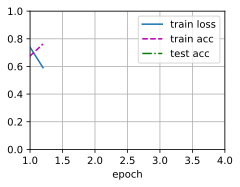

In [ ]:
lr, num_epochs = 0.001, 4
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
devices = d2l.try_all_gpus()
if not devices:
    devices = [torch.device('cpu')] # this is going to take very long time
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

In [ ]:
#@save
def predict_snli(net, vocab, premise, hypothesis):
    """Predict the logical relationship between the premise and hypothesis."""
    net.eval()
    premise = torch.tensor(vocab[premise], device=d2l.try_gpu())
    hypothesis = torch.tensor(vocab[hypothesis], device=d2l.try_gpu())
    label = torch.argmax(net([premise.reshape((1, -1)),
                           hypothesis.reshape((1, -1))]), dim=1)
    return 'entailment' if label == 0 else 'contradiction' if label == 1 \
            else 'neutral'

In [ ]:
predict_snli(net, vocab, ['he', 'is', 'good', '.'], ['he', 'is', 'bad', '.'])

**Key takeaways**
- Strong NLI performance can be achieved using only **MLPs and attention**.
- Attention provides explicit, interpretable soft alignments between sentences.
- Decomposability improves computational efficiency.
- Pretrained embeddings substantially improve convergence and accuracy.
- Limitation: lack of explicit word order modeling; complex syntax and long-range dependencies can be missed.

=====================================Fine-Tuning BERT for Sequence-Level and Token-Level Applications=====================================

#### Fine-Tuning BERT for Sequence-Level and Token-Level Applications  

This section explains how a **pretrained BERT model** can be adapted to a wide range of downstream NLP tasks through **fine-tuning**, using only lightweight task-specific output layers.

##### Overview

- BERT is pretrained on large unlabeled corpora to learn deep, contextual word representations.
- **Fine-tuning** means continuing training on a labeled downstream task while updating **all** model parameters.
- The same BERT backbone can support many tasks with minimal architectural changes.

#### Sequence-Level Tasks

#### 1. Single-Sequence Classification

- Input: a single text sequence (e.g., sentiment analysis).
- The special token **`[CLS]`** is added at the beginning of the sequence.
- BERT outputs contextual embeddings for all tokens.
- The final hidden state of `[CLS]` is fed into a classifier (e.g., linear layer or MLP) to predict the label.

![single Sequence Classification](./Images/singleTextClassification.png)

##### 2. Text-Pair Classification / Regression

- Input: two sequences (e.g., natural language inference, semantic similarity).
- Input format: [CLS] text₁ [SEP] text₂ [SEP]

- Both sequences are encoded jointly by BERT.
- The `[CLS]` representation is used for:
  - classification (discrete labels), or
  - regression (continuous scores).

![Text pair Classification](./Images/textPairClassification.png)

#### Token-Level Tasks

##### 1. Text Tagging (e.g., POS, NER)

- BERT outputs one contextual embedding **per token**.
- Each token embedding is passed through the same classifier to predict a tag.
- Useful for tasks where every token needs a label.

![text tagging](./Images/textTagging.png)

##### 2. Question Answering

- Input combines a question and a passage as a text pair.
- BERT produces embeddings for all tokens in the combined sequence.
- Two classifiers predict:
  - the **start position**, and
  - the **end position**
of the answer span in the passage.

![Question Answering](./Images/questionAnswering.png)

##### Why BERT Is Easy to Fine-Tune

- The **Transformer encoder** remains unchanged across tasks.
- Only small output heads differ between:
  - sequence-level tasks, and
  - token-level tasks.
- This design makes BERT highly reusable and efficient for many NLP applications.

##### Key Takeaways

- Fine-tuning adapts pretrained BERT to downstream tasks with minimal changes.
- Use **`[CLS]` embeddings** for sequence-level predictions.
- Use **token embeddings** for token-level predictions.
- This unified framework enables strong performance across diverse NLP tasks.



===============================Natural Language Inference: Fine-Tuning BERT====================================

![BERT-MLP](./Images/BertMLP.png)

#### Fine-Tuning BERT

This section explains how to **fine-tune a pretrained BERT model** for the **Natural Language Inference (NLI)** task, using it as a **sequence-level text pair classification model**.

##### Task Definition: Natural Language Inference (NLI)

- Input: a **pair of sentences**
  - **Premise**
  - **Hypothesis**
- Output: one of three labels:
  - **Entailment** — the hypothesis logically follows from the premise
  - **Contradiction** — the hypothesis contradicts the premise
  - **Neutral** — neither entailment nor contradiction

NLI is treated as a **text pair classification** problem.

##### BERT Fine-Tuning Setup

- A pretrained **BERT encoder** produces contextual representations for all tokens.
- A lightweight **classification head (MLP)** is added on top.
- The model uses the final hidden representation of the **`[CLS]` token** as the aggregate representation of the sentence pair.
- The classifier maps `[CLS]` to the three NLI labels.

##### Input Representation

- Premise and hypothesis are packed into a single input sequence: [CLS] premise [SEP] hypothesis [SEP]
- **Segment (token type) IDs** distinguish premise vs. hypothesis.
- Inputs are truncated or padded to a fixed maximum length.

##### Dataset Handling (SNLI)

- The SNLI dataset is adapted for BERT using a custom dataset class.
- Each training example includes:
  - token IDs
  - segment IDs
  - valid sequence length
  - ground-truth NLI label
- This format allows efficient batching and fine-tuning.

##### Training

- The entire model (BERT + classifier) is trained **end-to-end**.
- Optimization uses **cross-entropy loss** over the three NLI classes.
- The section demonstrates fine-tuning with:
- a smaller BERT model (hardware-friendly), or
- a full `bert.base` model for higher accuracy.

##### Key Takeaways

- NLI can be framed as a **sequence-level classification** task using BERT.
- The `[CLS]` token serves as a powerful summary of sentence pairs.
- Fine-tuning requires only a small task-specific head on top of pretrained BERT.
- This approach achieves strong performance on NLI benchmarks like SNLI.

In [ ]:
import json
import multiprocessing
import os
import torch
from torch import nn
from d2l import torch as d2l

In [ ]:
d2l.DATA_HUB['bert.base'] = (d2l.DATA_URL + 'bert.base.torch.zip', '225d66f04cae318b841a13d32af3acc165f253ac')
d2l.DATA_HUB['bert.small'] = (d2l.DATA_URL + 'bert.small.torch.zip', 'c72329e68a732bef0452e4b96a1c341c8910f81f')

In [ ]:
def load_pretrained_model(pretrained_model, num_hiddens, ffn_num_hiddens,
                          num_heads, num_blks, dropout, max_len, devices):
    data_dir = d2l.download_extract(pretrained_model)
    # Define an empty vocabulary to load the predefined vocabulary
    vocab = d2l.Vocab()
    vocab.idx_to_token = json.load(open(os.path.join(data_dir, 'vocab.json')))
    vocab.token_to_idx = {token: idx for idx, token in enumerate(vocab.idx_to_token)}
    bert = d2l.BERTModel(
        len(vocab),
        num_hiddens,
        ffn_num_hiddens=ffn_num_hiddens,
        num_heads=4,
        num_blks=2,
        dropout=0.2,
        max_len=max_len)
    # Load pretrained BERT parameters
    bert.load_state_dict(torch.load(os.path.join(data_dir, 'pretrained.params')))
    return bert, vocab

In [ ]:
devices = d2l.try_all_gpus()
bert, vocab = load_pretrained_model(
    'bert.small', num_hiddens=256, ffn_num_hiddens=512, num_heads=4,
    num_blks=2, dropout=0.1, max_len=512, devices=devices)

In [ ]:
class SNLIBERTDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, max_len, vocab=None):
        all_premise_hypothesis_tokens = [[
            p_tokens, h_tokens] for p_tokens, h_tokens in zip(
            *[d2l.tokenize([s.lower() for s in sentences])
              for sentences in dataset[:2]])]

        self.labels = torch.tensor(dataset[2])
        self.vocab = vocab
        self.max_len = max_len
        (self.all_token_ids, self.all_segments, self.valid_lens) = self._preprocess(all_premise_hypothesis_tokens)
        print('read ' + str(len(self.all_token_ids)) + ' examples')

    def _preprocess(self, all_premise_hypothesis_tokens):
        pool = multiprocessing.Pool(4)  # Use 4 worker processes
        out = pool.map(self._mp_worker, all_premise_hypothesis_tokens)
        all_token_ids = [
            token_ids for token_ids, segments, valid_len in out]
        all_segments = [segments for token_ids, segments, valid_len in out]
        valid_lens = [valid_len for token_ids, segments, valid_len in out]
        return (torch.tensor(all_token_ids, dtype=torch.long),
                torch.tensor(all_segments, dtype=torch.long),
                torch.tensor(valid_lens))

    def _mp_worker(self, premise_hypothesis_tokens):
        p_tokens, h_tokens = premise_hypothesis_tokens
        self._truncate_pair_of_tokens(p_tokens, h_tokens)
        tokens, segments = d2l.get_tokens_and_segments(p_tokens, h_tokens)
        token_ids = self.vocab[tokens] + [self.vocab['<pad>']] \
                             * (self.max_len - len(tokens))
        segments = segments + [0] * (self.max_len - len(segments))
        valid_len = len(tokens)
        return token_ids, segments, valid_len

    def _truncate_pair_of_tokens(self, p_tokens, h_tokens):
        # Reserve slots for '<CLS>', '<SEP>', and '<SEP>' tokens for the BERT
        # input
        while len(p_tokens) + len(h_tokens) > self.max_len - 3:
            if len(p_tokens) > len(h_tokens):
                p_tokens.pop()
            else:
                h_tokens.pop()

    def __getitem__(self, idx):
        return (self.all_token_ids[idx], self.all_segments[idx],
                self.valid_lens[idx]), self.labels[idx]

    def __len__(self):
        return len(self.all_token_ids)

In [ ]:
# Reduce `batch_size` if there is an out of memory error. In the original BERT
# model, `max_len` = 512
batch_size, max_len, num_workers = 512, 128, d2l.get_dataloader_workers()
data_dir = d2l.download_extract('SNLI')
train_set = SNLIBERTDataset(d2l.read_snli(data_dir, True), max_len, vocab)
test_set = SNLIBERTDataset(d2l.read_snli(data_dir, False), max_len, vocab)
train_iter = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True,
                                   num_workers=num_workers)
test_iter = torch.utils.data.DataLoader(test_set, batch_size,
                                  num_workers=num_workers)

In [ ]:
class BERTClassifier(nn.Module):
    def __init__(self, bert):
        super(BERTClassifier, self).__init__()
        self.encoder = bert.encoder
        self.hidden = bert.hidden
        self.output = nn.LazyLinear(3)

    def forward(self, inputs):
        tokens_X, segments_X, valid_lens_x = inputs
        encoded_X = self.encoder(tokens_X, segments_X, valid_lens_x)
        return self.output(self.hidden(encoded_X[:, 0, :]))

In [ ]:
net = BERTClassifier(bert)

In [ ]:
lr, num_epochs = 1e-4, 5
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction='none')
net(next(iter(train_iter))[0])
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)